In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
from utils.backtest import calc_single_asset_backtest
from utils.data_loaders import load_clc_db_records
from utils.features import construct_features_batch
from utils.data_handling import merge_asset_data, split_by_date
from utils.loss_functions import return_loss, sharpe_loss, return_loss_dummy, sharpe_loss_dummy

Using TensorFlow backend.


In [4]:
SIGMA_TARGET = 0.15

In [5]:
RAD_DATA_PATH = '../data/clc/rad/'
FED_DATA_PATH = '../data/FEDFUNDS.csv'

In [6]:
clc = load_clc_db_records(RAD_DATA_PATH, FED_DATA_PATH)

In [7]:
assets_to_use = ['AN', 'BN', 'CC', 'CN', 'CT', 'DT', 'DX', 'EC', 'FB', 'FF', 'FN',
       'FX', 'GI', 'GS', 'JN', 'JO', 'KC', 'KW', 'LB', 'LX', 'MD', 'MW',
       'NK', 'NR', 'PA', 'SB', 'SN', 'SP', 'SS', 'TU', 'TY', 'US', 'W',
       'ZA', 'ZB', 'ZC', 'ZF', 'ZG', 'ZH', 'ZI', 'ZK', 'ZL', 'ZM', 'ZN',
       'ZO', 'ZP', 'ZR', 'ZS', 'ZT', 'ZU', 'ZW', 'ZZ']
exclude_assets = ['FF', 'EC', 'TU', 'SS']
assets_to_use = list(set(assets_to_use) - set(exclude_assets))

temp_clc = {}
for asset, df in clc.items():
    if asset in assets_to_use:
        temp_clc[asset] = df
clc = temp_clc

In [8]:
clc = construct_features_batch(clc)
for asset, df in clc.items():
    df.set_index('Date', inplace=True)

../utils/features.py:52: RuntimeWarning: invalid value encountered in log
  df['Sigma_Norm'] = np.log(df['Sigma'] / df['Sigma'].rolling(181).mean())


In [9]:
def perform_monthly_lag_return_regression(df, month_lag=1, verbose=False):
    monthly_returns = ((1 + df.Returns_Daily).resample('M').prod() - 1).rename('Monthly_Returns')
    monthly_sigma = np.sqrt((df.Returns_Daily ** 2).resample('M').sum()).rename('Monthly_Sigma')
    norm_lag_return = monthly_returns.shift(-1) / monthly_sigma
    next_norm_lag_return = norm_lag_return.shift(-month_lag)
    reg_df = pd.DataFrame([norm_lag_return, next_norm_lag_return], index=['norm_returns', 'next_norm_returns']).T
    reg_df.dropna(inplace=True)
    X = reg_df['norm_returns']
    y = reg_df['next_norm_returns']
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HC3')
    if verbose:
        print(results.summary())
    return results.pvalues[-1]

def perform_monthly_lag_return_regression_all_data(clc, month_lag=[1], verbose=False):
    reg_dfs = {}
    for asset, df in clc.items():
        monthly_returns = ((1 + df.Returns_Daily).resample('M').prod() - 1).rename('Monthly_Returns')
        df['Parkinson_Volatility'] = np.sqrt(252 * (1 / (4 * np.log(2))) * (np.log(df['High'] / df['Low']) ** 2)) # np.sqrt((df.Returns_Daily ** 2).resample('M').sum()).rename('Monthly_Sigma')
        monthly_sigma = np.sqrt(21) * df['Parkinson_Volatility'].resample('M').mean()
        norm_lag_return = monthly_returns.shift(-1) / monthly_sigma
        lag_data = []
        for lag in month_lag:
            lag_data.append(norm_lag_return.shift(-lag))
        reg_df = pd.DataFrame([norm_lag_return] + lag_data, index=['norm_returns'] + ['lag_' + str(lag) for lag in month_lag]).T
        reg_df.dropna(inplace=True)
        reg_dfs[asset] = reg_df
    reg_dfs = [df for asset, df in reg_dfs.items()]
    reg_df = pd.concat(reg_dfs, ignore_index=True)
    reg_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    reg_df.dropna(inplace=True)
    X = reg_df['norm_returns']
    X = sm.add_constant(X)
    result_collection = {}
    for lag in tqdm(month_lag):
        y = reg_df['lag_' + str(lag)]
        model = sm.OLS(y, X)
        results = model.fit(cov_type='HC3')
        result_collection[lag] = {'pvalue': results.pvalues[-1], 'tvalue': results.tvalues[-1]}
        if verbose:
            print(results.summary())
    return result_collection

def perform_monthly_lag_return_regression_by_asset(clc, month_lag=[1], verbose=False):
    asset_collection = {}
    for asset, df in tqdm(clc.items()):
        monthly_returns = ((1 + df.Returns_Daily).resample('M').prod() - 1).rename('Monthly_Returns')
        df['Parkinson_Volatility'] = np.sqrt(252 * (1 / (4 * np.log(2))) * (np.log(df['High'] / df['Low']) ** 2)) # np.sqrt((df.Returns_Daily ** 2).resample('M').sum()).rename('Monthly_Sigma')
        monthly_sigma = np.sqrt(21) * df['Parkinson_Volatility'].resample('M').mean()
        norm_lag_return = monthly_returns.shift(-1) / monthly_sigma
        lag_data = []
        for lag in month_lag:
            lag_data.append(norm_lag_return.shift(-lag))
        reg_df = pd.DataFrame([norm_lag_return] + lag_data, index=['norm_returns'] + ['lag_' + str(lag) for lag in month_lag]).T
        reg_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        reg_df.dropna(inplace=True)
        X = reg_df['norm_returns']
        X = sm.add_constant(X)
        result_collection = {}
        for lag in month_lag:
            y = reg_df['lag_' + str(lag)]
            model = sm.OLS(y, X)
            results = model.fit(cov_type='HC3')
            result_collection[lag] = {'pvalue': results.pvalues[-1], 'tvalue': results.tvalues[-1]}
        asset_collection[asset] = result_collection
    return asset_collection

In [91]:
# perform_monthly_lag_return_regression(df, month_lag=8, verbose=True)
batch_results = perform_monthly_lag_return_regression_all_data(clc, month_lag=list(range(1, 61)))

/home/maxlamberti/anaconda3/envs/AI_ENV/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
100%|██████████| 60/60 [01:25<00:00,  1.43s/it]


In [12]:
single_asset_results = perform_monthly_lag_return_regression_by_asset(clc, month_lag=list(range(1, 36)))

100%|██████████| 48/48 [00:05<00:00,  8.37it/s]


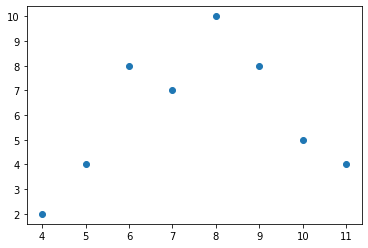

In [16]:
from collections import Counter

counts = Counter(lag_count)
vals = [k for k, v in counts.items()]
occurances = [v for k, v in counts.items()]
plt.plot(vals, occurances, 'o')

In [12]:
# lag_count = []
# for asset, result in single_asset_results.items():
# #     pvals_asset = [val['pvalue'] for k, val in result.items()]
#     tvals_asset = np.array([val['tvalue'] for k, val in result.items()])
#     print(asset)
#     print(np.sum(tvals_asset[:12] > 0))
#     print()
#     lag_count.append(np.sum(tvals_asset[:12] > 0))
# # #     plt.bar(list(range(1, 36)), tvals_asset)
# # #     plt.title(asset)
# # #     plt.show()

In [13]:
# batch_results

In [92]:
pvals = [val['pvalue'] for k, val in batch_results.items()]
tvals = [val['tvalue'] for k, val in batch_results.items()]

<BarContainer object of 60 artists>

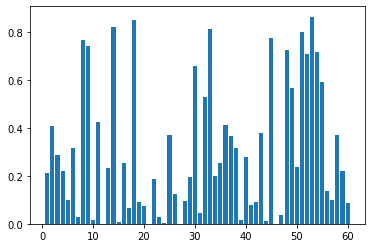

In [93]:
plt.bar(list(range(1, 61)), pvals)

In [95]:
window_size = 12
sig = 1
max_lag = len(tvals) + 1
mean_coeff = pd.Series(tvals, index=list(range(1, max_lag))).rolling(window_size, center=True, min_periods=0).mean()
std_coeff = pd.Series(tvals, index=list(range(1, max_lag))).rolling(window_size, center=True, min_periods=0).std()

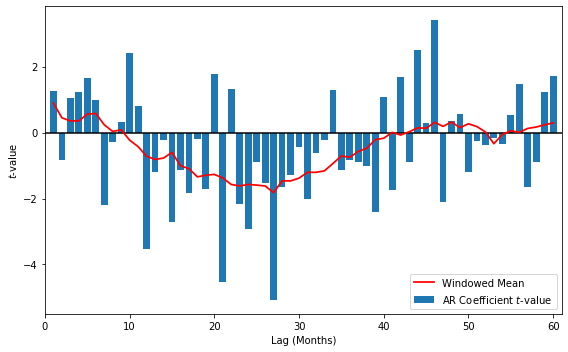

In [106]:
plt.figure(figsize=(8,5))
plt.bar(list(range(1, max_lag)), tvals, label='AR Coefficient $t$-value')
mean_coeff.plot(color='r', lw=1.75, label='Windowed Mean')
# (mean_coeff + sig *  std_coeff).plot(color='k', alpha=0.2)
# (mean_coeff - sig * std_coeff).plot(color='k', alpha=0.2)
plt.hlines(0, -10, max_lag + 2)
plt.xlim(0, max_lag)
plt.ylabel('$t$-value')
plt.xlabel('Lag (Months)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('/home/maxlamberti/Code/time-series-momentum/plots/ar_lag_plot_60.png', dpi=350)

In [14]:
norm_lag_return = df.Next_Returns_Daily / df.Sigma
next_norm_lag_return = df.Next_Returns_Daily.shift(-1) / df.Sigma
reg_df = pd.DataFrame([norm_lag_return, next_norm_lag_return], index=['norm_returns', 'next_norm_returns']).T
reg_df.dropna(inplace=True)

In [34]:
X = reg_df['norm_returns']
y = reg_df['next_norm_returns']
X = sm.add_constant(X)

In [35]:
model = sm.OLS(y, X)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      next_norm_returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.056
Date:                Thu, 19 Mar 2020   Prob (F-statistic):             0.0805
Time:                        20:35:08   Log-Likelihood:                -9575.6
No. Observations:                6496   AIC:                         1.916e+04
Df Residuals:                    6494   BIC:                         1.917e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0352      0.013      2.648   

In [36]:
results.pvalues[-1]

0.08045755616551362

In [37]:
results.tvalues[-1]

const           2.647612
norm_returns   -1.748037
dtype: float64